# Contents

This notebook's main purpose is to analyze the data gathered during CGP experiments.

# Imports

In [1]:
import pathlib
import pandas as pd
from typing import List
from IPython.display import Markdown
import numpy as np

import seaborn as sbn
import matplotlib.pyplot as plt
sbn.set()

In [2]:
# MATPLOTLIB CONFIG
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
# sliwkowy, grafitowy, sloneczny, wrzosowy
colors = ['#965F77', '#3C3C4C', '#FED542', '#B4A0AA']
sbn.set_palette(sbn.color_palette(colors))

# Paths

In [4]:
PROJECT_MAIN_PATH = pathlib.Path().absolute().parent
CODE_MAIN_PATH = PROJECT_MAIN_PATH / 'src'
DATA_MAIN_PATH = CODE_MAIN_PATH / 'data_gather'
CHARTS_MAIN_PATH = PROJECT_MAIN_PATH / 'charts/SA'

AND_GATE_CGPSA_PATH = DATA_MAIN_PATH / 'cgpsa/ANDgate'
AND_GATE_CGP_PATH = DATA_MAIN_PATH / 'cgp/ANDgate'

EVENCHECK_GATE_CGPSA_PATH = DATA_MAIN_PATH / 'cgpsa/EVENCHECKgate'
EVENCHECK_GATE_CGP_PATH = DATA_MAIN_PATH / 'cgp/EVENCHECKgate'

RANDOM_GATE_CGPSA_PATH = DATA_MAIN_PATH / 'cgpsa/RANDOMgate'
RANDOM_GATE_CGP_PATH = DATA_MAIN_PATH / 'cgp/RANDOMgate'

# Analysis

## Define metrics

Two metrics would be used:

CR - Correct Rate, defined as:

CR = # of simulations ended with the perfect solution / # of simulations

MNS - Mean Number of Steps, defined as:

MNS = sum(number_of_steps) / # of simulations

In [5]:
def correct_rate(df: pd.DataFrame, column='potential') -> float:
    return round(df[df[column]==0.0][column].count()/df[column].count() * 100, 2)

In [6]:
def mean_number_of_steps(df: pd.DataFrame, calc_column='iteration', filter_column='potential') -> float:
    return round(df[df[filter_column]==0.0][calc_column].mean(), 2)

In [7]:
def calc_mns_series(df: pd.DataFrame, groupby: str) -> pd.DataFrame:
    indices = df[groupby].unique()
    results = {groupby: [], 'mns': []}
    for ind in indices:
        results[groupby].append(ind)
        results['mns'].append(mean_number_of_steps(df[df[groupby]==ind]))
    return pd.DataFrame(results, index=results[groupby])

In [8]:
def calc_cr_series(df: pd.DataFrame, groupby: str) -> pd.DataFrame:
    indices = df[groupby].unique()
    results = {groupby: [], 'cr': []}
    for ind in indices:
        results[groupby].append(ind)
        results['cr'].append(correct_rate(df[df[groupby]==ind]))
    return pd.DataFrame(results, index=results[groupby])

## AND gate

### Data loading

In [9]:
df_and_cgp_geom_raw = pd.read_csv(AND_GATE_CGPSA_PATH / "cgpsa_geom99_5000steps_numsim200_numcopies5_annealing100_ANDgate.csv")
df_and_cgp_lin_raw = pd.read_csv(AND_GATE_CGPSA_PATH / "cgpsa_linear_5000steps_numsim200_numcopies5_annealing100_ANDgate.csv")
df_and_cgp_log_raw = pd.read_csv(AND_GATE_CGPSA_PATH / "cgpsa_log_5000steps_numsim200_numcopies5_annealing100_ANDgate.csv")
df_and_cgp_alone_raw = pd.read_csv(AND_GATE_CGP_PATH / "cgp_alone_5000steps_numsim200_numcopies5_annealing100.csv")

In [10]:
schemes = ['geom', 'lin', 'log', 'cgp_alone']

In [11]:
def concat_data(dfs: List[pd.DataFrame], flags: List[str], columns={'potential', 'iteration'}) -> pd.DataFrame:
    for df, flag in zip(dfs, flags):
        all_cols = set(df.columns)
        cols_to_drop = all_cols - columns
        df.drop(cols_to_drop, axis=1, inplace=True)
        df['sa_type'] = flag
        
    cgp_data = pd.concat(dfs)
    cgp_data = cgp_data.reset_index()
    cgp_data = cgp_data.drop('index', axis=1) 
    
    return cgp_data

In [12]:
df_cgp_and_data = concat_data([df_and_cgp_geom_raw, 
                               df_and_cgp_lin_raw, 
                               df_and_cgp_log_raw, 
                               df_and_cgp_alone_raw], 
                              flags=schemes)

In [13]:
df_cgp_and_data

,potential,iteration,sa_type
0,0.0,4472,geom
1,0.0,158,geom
2,0.0,325,geom
3,0.0,2663,geom
4,0.0,2122,geom
...,...,...,...
795,0.0,750,cgp_alone
796,0.0,623,cgp_alone
797,0.0,820,cgp_alone
798,0.0,139,cgp_alone


In [14]:
def plot_hist(data, 
              save_path: pathlib.Path=None,  
              title='Hist', 
              legend=None, 
              ylabel='y', 
              xlabel='x', 
              yscale=None,
              bins=None,
              colors=colors
             ):
    """
    Function plots histograms as lines
    
    param data: list of pandas DataFrame's
    type data: list
    """
    if bins:
        bin_values, bin_edges, _ = plt.hist(data, bins=bins, color=colors[0])
    else:
        bin_values, bin_edges, _ = plt.hist(data, color=colors[0])
        
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if yscale:
        plt.yscale(yscale)
    plt.title(title)
    if legend:
        plt.legend(legend)
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    if save_path:
        plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')
    plt.show()
    
    return bin_values, bin_edges, bin_centers

In [15]:
def plot_hist_line(data: pd.DataFrame, 
                   column: str, 
                   schemes: List[str], 
                   save_path: pathlib.Path, 
                   title='Chart', 
                   ylabel='y', 
                   xlabel='x',
                   xscale=None,
                   yscale=None,
                   xlim=(0,4900),
                   ylim=(0, 1.),
                   colors=colors
                  ) -> None:
    """
    Function plots histograms as lines
    
    param data: list of pandas DataFrame's
    type data: list
    """
    
#     num_sim = len(data[data.sa_type==schemes[0]][column])
    
#     data_copy = [data[data.sa_type==scheme][data.potential==0.][column] for scheme in schemes]
    
#     bin_values, bin_edges, bin_centers = plot_hist(data_copy, ylabel=ylabel, xlabel=xlabel)
    
#     bin_values = np.array(bin_values) * 100 / num_sim
    
#     for num_set in range(len(data_copy)):
#         if len(data_copy)==1:
#             plt.plot(bin_centers, bin_values)
#         else:
#             plt.plot(bin_centers, bin_values[num_set])

    # data_copy = [data[data.sa_type==scheme][data.potential==0.][column] for scheme in schemes]
    data_copy = [data[data.sa_type==scheme][column] for scheme in schemes]
    
    fig, ax = plt.subplots(figsize=(7,4))
    for dataset, color in zip(data_copy, colors):
        sbn.kdeplot(dataset, ax=ax, cumulative=True, bw_method=0.01, color=color)
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if xscale:
        plt.xscale(xscale)
    if yscale:
        plt.yscale(yscale)
    plt.title(title)
    plt.legend(schemes)
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')
    plt.show()

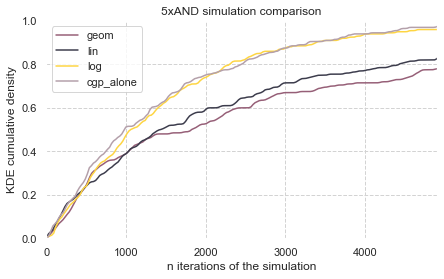

In [16]:
plot_hist_line(df_cgp_and_data, 
               column='iteration',
               schemes=schemes,
               save_path=CHARTS_MAIN_PATH,
               xlabel='n iterations of the simulation',
               ylabel='KDE cumulative density',
               title='5xAND simulation comparison'
              )

### AND gate objective function values

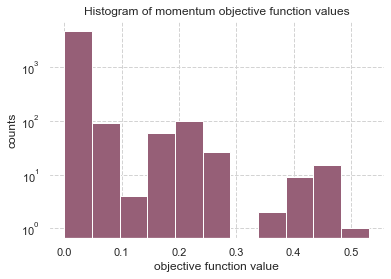

(array([4.772e+03, 9.100e+01, 4.000e+00, 5.900e+01, 9.900e+01, 2.600e+01,
        0.000e+00, 2.000e+00, 9.000e+00, 1.500e+01, 1.000e+00]),
 array([0.        , 0.04829545, 0.09659091, 0.14488636, 0.19318182,
        0.24147727, 0.28977273, 0.33806818, 0.38636364, 0.43465909,
        0.48295455, 0.53125   ]),
 array([0.02414773, 0.07244318, 0.12073864, 0.16903409, 0.21732955,
        0.265625  , 0.31392045, 0.36221591, 0.41051136, 0.45880682,
        0.50710227]))

In [17]:
df_and_every_step_raw = pd.read_csv(AND_GATE_CGPSA_PATH / "every_step_momentum_data_ANDgate.txt")

plot_hist(data=df_and_every_step_raw.potential,
          save_path=CHARTS_MAIN_PATH,
          title='Histogram of momentum objective function values',
          xlabel='objective function value',
          ylabel='counts',
          yscale='log',
          bins=len(df_and_every_step_raw.potential.unique())
         )

In [18]:
df_and_every_step_raw.potential.value_counts()

0.03125    4770
0.21875      99
0.09375      91
0.15625      59
0.28125      26
0.46875      15
0.40625       9
0.12500       4
0.34375       2
0.00000       2
0.53125       1
Name: potential, dtype: int64

### CR - AND gate

In [19]:
cr_and_gate_geom = correct_rate(df_cgp_and_data[df_cgp_and_data.sa_type=='geom'])
Markdown(f'#### AND-gate geom Correct Rate: {cr_and_gate_geom}')

#### AND-gate geom Correct Rate: 79.0

In [20]:
cr_and_gate_lin = correct_rate(df_cgp_and_data[df_cgp_and_data.sa_type=='lin'])
Markdown(f'#### AND-gate lin Correct Rate: {cr_and_gate_lin}')

#### AND-gate lin Correct Rate: 84.0

In [21]:
cr_and_gate_log = correct_rate(df_cgp_and_data[df_cgp_and_data.sa_type=='log'])
Markdown(f'#### AND-gate log Correct Rate: {cr_and_gate_log}')

#### AND-gate log Correct Rate: 96.5

In [22]:
cr_and_gate_cgp_alone = correct_rate(df_cgp_and_data[df_cgp_and_data.sa_type=='cgp_alone'])
Markdown(f'#### AND-gate cgp_alone Correct Rate: {cr_and_gate_cgp_alone}')

#### AND-gate cgp_alone Correct Rate: 98.0

### MNS

In [23]:
mns_and_gate_geom = mean_number_of_steps(df_cgp_and_data[df_cgp_and_data.sa_type=='geom'])
Markdown(f'#### AND-gate geom Mean Number of Steps: {mns_and_gate_geom}')

#### AND-gate geom Mean Number of Steps: 1531.65

In [24]:
mns_and_gate_lin = mean_number_of_steps(df_cgp_and_data[df_cgp_and_data.sa_type=='lin'])
Markdown(f'#### AND-gate lin Mean Number of Steps: {mns_and_gate_lin}')

#### AND-gate lin Mean Number of Steps: 1521.56

In [25]:
mns_and_gate_log = mean_number_of_steps(df_cgp_and_data[df_cgp_and_data.sa_type=='log'])
Markdown(f'#### AND-gate log Mean Number of Steps: {mns_and_gate_log}')

#### AND-gate log Mean Number of Steps: 1333.57

In [26]:
mns_and_gate_cgp_alone = mean_number_of_steps(df_cgp_and_data[df_cgp_and_data.sa_type=='cgp_alone'])
Markdown(f'#### AND-gate cgp_alone Mean Number of Steps: {mns_and_gate_cgp_alone}')

#### AND-gate cgp_alone Mean Number of Steps: 1336.37

#### Wniosek

Uzyskano współczynnik wskazujący stosunek liczby znalezionych rozwiązań do wszystkich prób dla wszystkich wariantów algorytmu CGP+SA oraz samego CGP. Wyniki przedstwiono w wartościach procentowych.

wsp = <# idealnych rozwiązań> / <# prób>

Parametry symulacji:

<# prób> = 200 (dla każdego wariantu)
<# kopii podczas mutacji> = 5
<max # kroków symulacji> = 5000
<początkowa wartość parametru T> = 100.

1. CGP: 98 %
2. CGP+SA(geom): 79 %
3. CGP+SA(lin): 84 %
4. CGP+SA(log): 96.5 %

# EVENcheck gate

Bramka sprawdza parzystość bitów wejściowych.

In [27]:
df_evencheck_cgp_geom_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "cgpsa_geom99_steps5000_numsim300_numcopies5_annealing100_evencheck.csv")
df_evencheck_cgp_lin_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "cgpsa_linear_steps5000_numsim300_numcopies5_annealing100_evencheck.csv")
df_evencheck_cgp_log_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "cgpsa_log_steps5000_numsim300_numcopies5_annealing100_evencheck.csv")
df_evencheck_cgp_alone_raw  = pd.read_csv(EVENCHECK_GATE_CGP_PATH / "cgpsa_None_steps5000_numsim300_numcopies5_annealing100_evencheck.csv")

In [28]:
df_cgp_evencheck_data = concat_data([df_evencheck_cgp_geom_raw, 
                                     df_evencheck_cgp_lin_raw, 
                                     df_evencheck_cgp_log_raw, 
                                     df_evencheck_cgp_alone_raw], 
                                    flags=schemes)

## CGP SA(różne schematy spadku T) + CGP alone

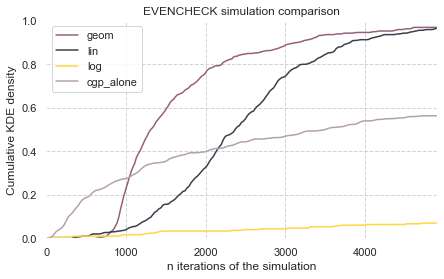

In [29]:
plot_hist_line(data=df_cgp_evencheck_data,
               title='EVENCHECK simulation comparison',
               ylabel='Cumulative KDE density',
               xlabel='n iterations of the simulation',
               column='iteration',
               schemes=schemes,
               save_path=CHARTS_MAIN_PATH
              )

In [30]:
cr_evencheck_gate_geom = correct_rate(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='geom'])
Markdown(f'#### EVENCHECK-gate geom Correct Rate: {cr_evencheck_gate_geom}')

#### EVENCHECK-gate geom Correct Rate: 97.0

In [31]:
cr_evencheck_gate_lin = correct_rate(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='lin'])
Markdown(f'#### EVENCHECK-gate lin Correct Rate: {cr_evencheck_gate_lin}')

#### EVENCHECK-gate lin Correct Rate: 96.67

In [32]:
cr_evencheck_gate_log = correct_rate(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='log'])
Markdown(f'#### EVENCHECK-gate log Correct Rate: {cr_evencheck_gate_log}')

#### EVENCHECK-gate log Correct Rate: 7.0

In [33]:
cr_evencheck_gate_cgp_alone = correct_rate(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='cgp_alone'])
Markdown(f'#### EVENCHECK-gate cgp_alone Correct Rate: {cr_evencheck_gate_cgp_alone}')

#### EVENCHECK-gate cgp_alone Correct Rate: 56.33

### MNS

In [34]:
mns_evencheck_gate_geom = mean_number_of_steps(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='geom'])
Markdown(f'#### AND-gate geom Mean Number of Steps: {mns_evencheck_gate_geom}')

#### AND-gate geom Mean Number of Steps: 1586.95

In [35]:
mns_evencheck_gate_lin = mean_number_of_steps(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='lin'])
Markdown(f'#### AND-gate lin Mean Number of Steps: {mns_evencheck_gate_lin}')

#### AND-gate lin Mean Number of Steps: 2397.92

In [36]:
mns_evencheck_gate_log = mean_number_of_steps(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='log'])
Markdown(f'#### AND-gate log Mean Number of Steps: {mns_evencheck_gate_log}')

#### AND-gate log Mean Number of Steps: 2230.9

In [37]:
mns_evencheck_gate_cgp_alone = mean_number_of_steps(df_cgp_evencheck_data[df_cgp_evencheck_data.sa_type=='cgp_alone'])
Markdown(f'#### AND-gate cgp_alone Mean Number of Steps: {mns_evencheck_gate_cgp_alone}')

#### AND-gate cgp_alone Mean Number of Steps: 1427.35

#### Wniosek

Zebrane dane z 300 symulacji dla bramki sprawdzającej parzystość wyglądają znacznie lepiej niż dla bramki AND. Można zauważyć, że CGP z zaaplikowanym Symulowanym Wyrzażaniem z geometrycznym spadkiem temperatury wydaje się otrzymywać najlepsze wyniki, natomiast przy spadku logarytmicznym mamy wyniki bardzo kiepskie - praktycznie wszystkie symulacje nie znalazły optymalnego rozwiązania w zadanej liczbie kroków (5000). Samo CGP bez dodatkowych algorytmów zachowało się średnio dobrze - lepiej niż SA ze spadkiem logarytmicznym, a gorzej niż reszta - dużo nie rozwiązanych przypadków.

Wersja logarytmiczna wypada najgorzej prawdopodobnie z uwagi na fakt, że startując z T=100 na początku T spada dosyć szybko, lecz po jakimś czasie wypłaszcza się przy T ~ 10 i zaczyna spadać niezwykle wolno(prawie wcale) - tym samym nie osiągając T ~ 0, a to właśnie przy niskich temperaturach algorytm SA z reguły osiada w danym ekstremum kończąć błądzenie losowe.

Można uszeregować:

CGP+SA(geom) > CGP+SA(linear) > CGP alone > CGP+SA(log).

Powyższe wyniki wydają się zgodne z pracami badającymi algorytmy SA - najlepsze wyniki dla SA z geometryczną funkcją spadku T. Ponadto dodając SA do algorytmu powinniśmy uzyskać średnio lepsze wyniki niż przy braku SA, co także widać z otrzymanych danych z symulacji.

<# prób> = 300 (dla każdego wariantu)
<# kopii podczas mutacji> = 5
<max # kroków symulacji> = 5000
<początkowa wartość parametru T> = 100.

1. CGP: 56 %
2. CGP+SA(geom): 97 %
3. CGP+SA(lin): 96.7 %
4. CGP+SA(log): 7 %

# RandomGate

## Pierwsza próba

In [38]:
df_random_cgp_geom_raw  = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_geom_steps5000_numsim300_numcopies5_annealing100_randomgate.csv")
df_random_cgp_lin_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_linear_steps5000_numsim300_numcopies5_annealing100_randomgate.csv")
df_random_cgp_log_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_log_steps5000_numsim300_numcopies5_annealing100_randomgate.csv")
df_random_cgp_alone_raw = pd.read_csv(RANDOM_GATE_CGP_PATH / "cgpsa_None_steps5000_numsim300_numcopies5_annealing100_randomgate.csv")

In [39]:
df_cgp_random_data = concat_data([df_random_cgp_geom_raw, 
                                  df_random_cgp_lin_raw, 
                                  df_random_cgp_log_raw, 
                                  df_random_cgp_alone_raw], 
                                 flags=schemes)

/Users/math/Desktop/EDMI/Mgr/CGP_mgr/venv/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


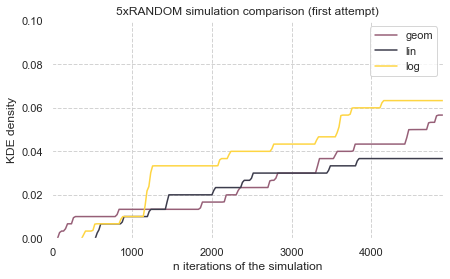

In [40]:
plot_hist_line(data=df_cgp_random_data,
               title='5xRANDOM simulation comparison (first attempt)',
               ylabel='KDE density',
               xlabel='n iterations of the simulation',
               schemes=schemes,
               column='iteration',
               save_path=CHARTS_MAIN_PATH,
               ylim=(0, 0.1)
              )

#### Wniosek

Wyniki są conajmniej dziwne dla pierwszej bramki losowej. Prawdopodobnie coś poszło nie tak przy generowaniu zbioru danych wejściowych, lub przypadek był specyficznie trudny do rozwiązania - do sprawdzenia!

Edit:

Dane wyglądają dobrze. Wygląda na to, że przypadek był wyjątkowo skomplikowany. Wylosujemy inną bramkę i powtórzymy test.

## Druga próba

Wygenerowano kolejną bramkę, aby skonfrontować wyniki.

In [41]:
df_random2_cgp_geom_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_geom_steps5000_numsim200_numcopies5_annealing100_randomgate2.csv")
df_random2_cgp_lin_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_linear_steps5000_numsim200_numcopies5_annealing100_randomgate2.csv")
df_random2_cgp_log_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "cgpsa_log_steps5000_numsim200_numcopies5_annealing100_randomgate2.csv")
df_random2_cgp_alone_raw  = pd.read_csv(RANDOM_GATE_CGP_PATH / 'cgpsa_None_steps5000_numsim200_numcopies5_annealing100_randomgate2.csv')

In [42]:
df_cgp_random2_data = concat_data([df_random2_cgp_geom_raw, 
                                   df_random2_cgp_lin_raw, 
                                   df_random2_cgp_log_raw, 
                                   df_random2_cgp_alone_raw], 
                                  flags=schemes)

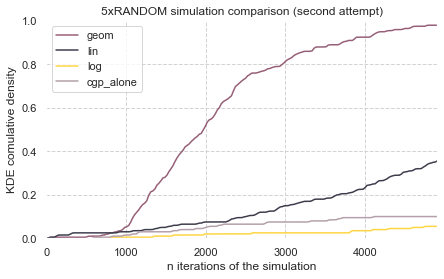

In [43]:
plot_hist_line(data=df_cgp_random2_data,
               title='5xRANDOM simulation comparison (second attempt)',
               ylabel='KDE comulative density',
               xlabel='n iterations of the simulation',
               schemes=schemes,
               column='iteration',
               save_path=CHARTS_MAIN_PATH
              )

### CR

In [44]:
cr_random2_gate_geom = correct_rate(df_cgp_random2_data[df_cgp_random2_data.sa_type=='geom'])
Markdown(f'#### RANDOM-gate geom Correct Rate: {cr_random2_gate_geom}')

#### RANDOM-gate geom Correct Rate: 98.5

In [45]:
cr_random2_gate_lin = correct_rate(df_cgp_random2_data[df_cgp_random2_data.sa_type=='lin'])
Markdown(f'#### RANDOM-gate lin Correct Rate: {cr_random2_gate_lin}')

#### RANDOM-gate lin Correct Rate: 37.5

In [46]:
cr_random2_gate_log = correct_rate(df_cgp_random2_data[df_cgp_random2_data.sa_type=='log'])
Markdown(f'#### RANDOM-gate log Correct Rate: {cr_random2_gate_log}')

#### RANDOM-gate log Correct Rate: 5.5

In [47]:
cr_random2_gate_cgp_alone = correct_rate(df_cgp_random2_data[df_cgp_random2_data.sa_type=='cgp_alone'])
Markdown(f'#### RANDOM-gate cgp_alone Correct Rate: {cr_random2_gate_cgp_alone}')

#### RANDOM-gate cgp_alone Correct Rate: 10.0

### MNS

In [48]:
mns_random2_gate_geom = mean_number_of_steps(df_cgp_random2_data[df_cgp_random2_data.sa_type=='geom'])
Markdown(f'#### RANDOM-gate geom Mean Number of Steps: {mns_random2_gate_geom}')

#### RANDOM-gate geom Mean Number of Steps: 2104.82

In [49]:
mns_random2_gate_lin = mean_number_of_steps(df_cgp_random2_data[df_cgp_random2_data.sa_type=='lin'])
Markdown(f'#### RANDOM-gate lin Mean Number of Steps: {mns_random2_gate_lin}')

#### RANDOM-gate lin Mean Number of Steps: 3226.91

In [50]:
mns_random2_gate_log = mean_number_of_steps(df_cgp_random2_data[df_cgp_random2_data.sa_type=='log'])
Markdown(f'#### RANDOM-gate log Mean Number of Steps: {mns_random2_gate_log}')

#### RANDOM-gate log Mean Number of Steps: 3054.27

In [51]:
mns_random2_gate_cgp_alone = mean_number_of_steps(df_cgp_random2_data[df_cgp_random2_data.sa_type=='cgp_alone'])
Markdown(f'#### RANDOM-gate cgp_alone Mean Number of Steps: {mns_random2_gate_cgp_alone}')

#### RANDOM-gate cgp_alone Mean Number of Steps: 2150.85

#### Wniosek

Dla innej bramki wyniki plasują się podobnie jak dla bramki EVENcheck. 

CGP+SA(geom) > CGP+SA(lin) > CGP alone > CGP+SA(log)

<# prób> = 200 (dla każdego wariantu)
<# kopii podczas mutacji> = 5
<max # kroków symulacji> = 5000
<początkowa wartość parametru T> = 100.

1. CGP: 10 %
2. CGP+SA(geom): 98.5 %
3. CGP+SA(lin): 37.5 %
4. CGP+SA(log): 5.5 %

# choosing optimal Max Step

In [52]:
def plot_line(dfs: List[pd.DataFrame], 
              legend: List[str],
              save_path: pathlib.Path,
              column: str,
              title: str,
              ylabel: str, 
              xlabel: str,
              xscale: str = None,
              yscale: str = None,
              xlim=None,
              colors=colors
             ) -> None:
    for df, color in zip(dfs, colors):
        plt.plot(df[column], color=color)
    plt.title(title)
    plt.legend(legend)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    if xlim:
        plt.xlim(xlim)
    if xscale:
        plt.xscale(xscale)
    if yscale:
        plt.yscale(yscale)
    plt.tight_layout()
    plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')

In [53]:
def plot_hists(df: pd.DataFrame, groupby: str, count: str) -> None:
    different_hists = df[groupby].unique()
    
    for val in different_hists:
        plt.hist(df[df[groupby] == val][count])
        plt.show()

In [54]:
def plot_bar(df: pd.DataFrame, 
             save_path: pathlib.Path,
             title: str,
             xlabel: str = 'Simulated Annealing type',
             y1_label: str = 'CR [%]',
             y2_label: str = 'MNS',
             x: str = 'sa_type',
             y_1: str = 'cr',
             y_2: str = 'mns',
             pad: float = 3.0,
             colors=colors
            ):
    
    df_1 = calc_cr_series(df, groupby=x)
    df_2 = calc_mns_series(df, groupby=x)
    
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    
    fig.suptitle(title)
    palette = sbn.color_palette(palette=colors, n_colors=4)
    
    sbn.barplot(ax=axes[0], data=df_1, x=x, y=y_1)
    
    for row, num in zip(df_1.iterrows(), [x for x in range(len(df_1.index))]):
        index, row = row
        axes[0].text(num, row.cr, round(row.cr,2), color='black', ha="center")
    
    sbn.barplot(ax=axes[1], data=df_2, x=x, y=y_2)
    
    for row, num in zip(df_2.iterrows(), [x for x in range(len(df_2.index))]):
        index, row = row
        axes[1].text(num, row.mns, round(row.mns), color='black', ha="center")
    
    axes[0].grid(color='lightgray', linestyle='--', linewidth=1)
    axes[1].grid(color='lightgray', linestyle='--', linewidth=1)
    
    axes[0].set(xlabel=xlabel)
    axes[1].set(xlabel=xlabel)
    
    axes[0].set(ylabel=y1_label)
    axes[1].set(ylabel=y2_label)
    
    fig.tight_layout(pad=3.0)
    
    fig.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')

In [55]:
df_evencheck_max_step_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "evencheck_gate_max_step_geom.csv")
df_random2_max_step_raw = pd.read_csv(RANDOM_GATE_CGPSA_PATH / "random_gate_max_step_geom.csv")
df_and_max_step_raw = pd.read_csv(AND_GATE_CGPSA_PATH / "and_gate_max_step_geom.csv")

gate_types = ['evencheck', 'random2', 'and']

df_cgp_max_step_raw = concat_data([df_evencheck_max_step_raw, 
                                   df_random2_max_step_raw, 
                                   df_and_max_step_raw], 
                                  flags=gate_types,
                                  columns={'iteration', 'potential', 'max_steps'}
                                 )

In [56]:
######### TODO ###########
# calc MNS and CR for those and choose the best max step for all the problems
# get the data for the max step in spite of different schemes

mean_step_evencheck = df_evencheck_max_step_raw[df_evencheck_max_step_raw.potential == 0.].groupby('max_steps').mean()
mean_step_random = df_random2_max_step_raw[df_random2_max_step_raw.potential == 0.].groupby('max_steps').mean()
mean_step_and = df_and_max_step_raw[df_and_max_step_raw.potential == 0.].groupby('max_steps').mean()
# mean_step_evencheck = df_evencheck_max_step_raw.groupby('max_steps').mean()
# mean_step_random = df_random2_max_step_raw.groupby('max_steps').mean()
# mean_step_and = df_and_max_step_raw.groupby('max_steps').mean()

dfs = [mean_step_evencheck, mean_step_random, mean_step_and]

for df, flag in zip(dfs, gate_types):
    all_cols = set(df.columns)
    df['sa_type'] = flag
        
mean_step_data = pd.concat(dfs)

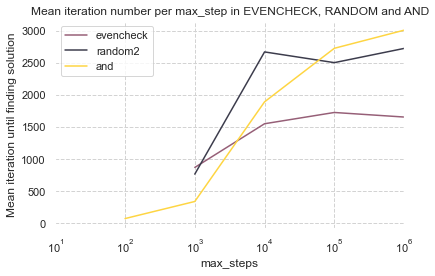

In [57]:
plot_line(dfs,
          legend=gate_types,
          title='Mean iteration number per max_step in EVENCHECK, RANDOM and AND',
          ylabel='Mean iteration until finding solution',
          xlabel='max_steps',
          column='iteration',
          save_path=CHARTS_MAIN_PATH,
          xscale='log',
          xlim=(10, 1000000)
         )

In [58]:
dfs

[           potential    iteration    sa_type
 max_steps                                   
 1000             0.0   869.142857  evencheck
 10000            0.0  1550.100000  evencheck
 100000           0.0  1725.533333  evencheck
 1000000          0.0  1654.566667  evencheck,
            potential    iteration  sa_type
 max_steps                                 
 1000             0.0   765.000000  random2
 10000            0.0  2668.793103  random2
 100000           0.0  2501.833333  random2
 1000000          0.0  2723.333333  random2,
            potential    iteration sa_type
 max_steps                                
 100              0.0    73.000000     and
 1000             0.0   339.142857     and
 10000            0.0  1891.250000     and
 100000           0.0  2725.166667     and
 1000000          0.0  3007.366667     and]

## MNS

In [59]:
calc_mns_series(df_evencheck_max_step_raw, groupby='max_steps')

,max_steps,mns
10,10,NaN
100,100,NaN
1000,1000,869.14
10000,10000,1550.10
100000,100000,1725.53
1000000,1000000,1654.57


In [60]:
calc_mns_series(df_random2_max_step_raw, groupby='max_steps')

,max_steps,mns
10,10,NaN
100,100,NaN
1000,1000,765.00
10000,10000,2668.79
100000,100000,2501.83
1000000,1000000,2723.33


In [61]:
calc_mns_series(df_and_max_step_raw, groupby='max_steps')

,max_steps,mns
10,10,NaN
100,100,73.00
1000,1000,339.14
10000,10000,1891.25
100000,100000,2725.17
1000000,1000000,3007.37


## CR

In [62]:
calc_cr_series(df_cgp_max_step_raw[df_cgp_max_step_raw.sa_type=='evencheck'], groupby='max_steps')

,max_steps,cr
10,10,0.00
100,100,0.00
1000,1000,23.33
10000,10000,100.00
100000,100000,100.00
1000000,1000000,100.00


In [63]:
calc_cr_series(df_cgp_max_step_raw[df_cgp_max_step_raw.sa_type=='and'], groupby='max_steps')

,max_steps,cr
10,10,0.00
100,100,3.33
1000,1000,23.33
10000,10000,93.33
100000,100000,100.00
1000000,1000000,100.00


In [64]:
calc_cr_series(df_cgp_max_step_raw[df_cgp_max_step_raw.sa_type=='random2'], groupby='max_steps')

,max_steps,cr
10,10,0.00
100,100,0.00
1000,1000,6.67
10000,10000,96.67
100000,100000,100.00
1000000,1000000,100.00


#### Comment 

Data from the simulation should be analysed further or the sampling should be redone.

The best max_step parameter for SA algorithms lay between 1000 and 10 000 steps. this area should be resampled.

## max step detailed search

In [65]:
df_max_step_detailed_geom_evencheck = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_max_step_1k_10k_geom.csv')
df_max_step_detailed_linear_evencheck = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_max_step_1k_10k_linear.csv')

### geom

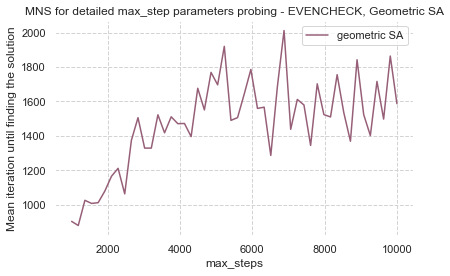

In [66]:
plot_line([calc_mns_series(df_max_step_detailed_geom_evencheck, groupby='max_steps')], 
             save_path=CHARTS_MAIN_PATH,
             column='mns',
             legend=['geometric SA'],
             title='MNS for detailed max_step parameters probing - EVENCHECK, Geometric SA',
             ylabel='Mean iteration until finding the solution',
             xlabel='max_steps'
            )

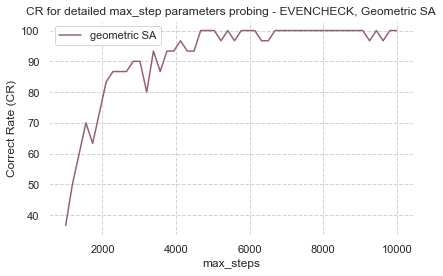

In [67]:
plot_line([calc_cr_series(df_max_step_detailed_geom_evencheck, groupby='max_steps')], 
             save_path=CHARTS_MAIN_PATH,
             column='cr',
             legend=['geometric SA'],
             title='CR for detailed max_step parameters probing - EVENCHECK, Geometric SA',
             ylabel='Correct Rate (CR)',
             xlabel='max_steps'
            )

### linear

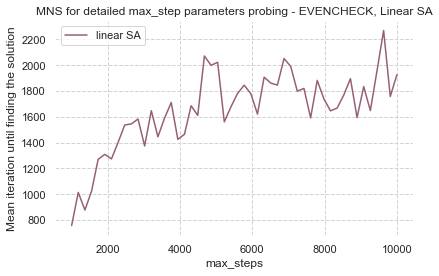

In [68]:
plot_line([calc_mns_series(df_max_step_detailed_linear_evencheck, groupby='max_steps')], 
             save_path=CHARTS_MAIN_PATH,
             column='mns',
             legend=['linear SA'],
             title='MNS for detailed max_step parameters probing - EVENCHECK, Linear SA',
             ylabel='Mean iteration until finding the solution',
             xlabel='max_steps'
            )

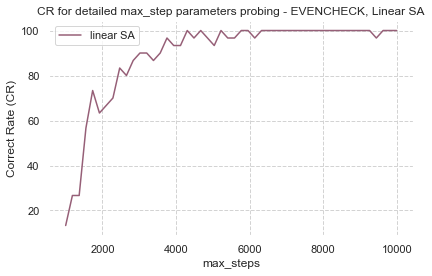

In [69]:
plot_line([calc_cr_series(df_max_step_detailed_linear_evencheck, groupby='max_steps')], 
             save_path=CHARTS_MAIN_PATH,
             column='cr',
             legend=['linear SA'],
             title='CR for detailed max_step parameters probing - EVENCHECK, Linear SA',
             ylabel='Correct Rate (CR)',
             xlabel='max_steps'
            )

# choosing the best Annealing Parameter for every scheme

## first sampling

In [70]:
even_gate_linear_10_200_20 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_10_200_linear.csv')
even_gate_geom_10_200_20 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_10_200_geom.csv')
even_gate_log_10_200_20 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_10_200_log.csv')

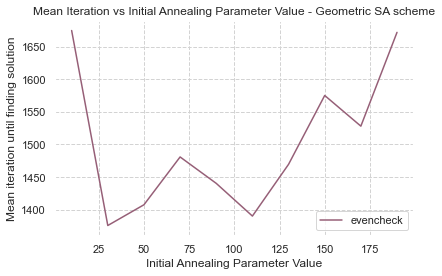

In [71]:
plot_line([even_gate_geom_10_200_20.groupby('annealing_param').mean()[['iteration']]],
          legend=gate_types,
          title='Mean Iteration vs Initial Annealing Parameter Value - Geometric SA scheme',
          ylabel='Mean iteration until finding solution',
          xlabel='Initial Annealing Parameter Value',
          column='iteration',
          save_path=CHARTS_MAIN_PATH,
         )

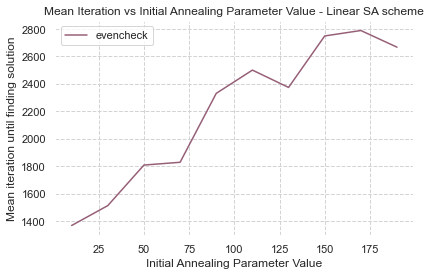

In [72]:
plot_line([even_gate_linear_10_200_20.groupby('annealing_param').mean()[['iteration']]],
          legend=gate_types,
          title='Mean Iteration vs Initial Annealing Parameter Value - Linear SA scheme',
          ylabel='Mean iteration until finding solution',
          xlabel='Initial Annealing Parameter Value',
          column='iteration',
          save_path=CHARTS_MAIN_PATH,
         )

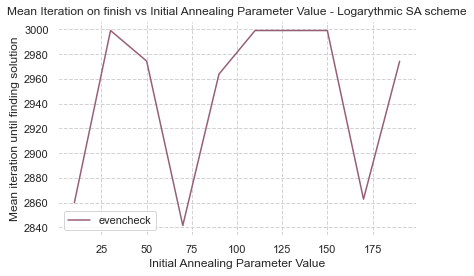

In [73]:
plot_line([even_gate_log_10_200_20.groupby('annealing_param').mean()[['iteration']]],
          legend=gate_types,
          title='Mean Iteration on finish vs Initial Annealing Parameter Value - Logarythmic SA scheme',
          ylabel='Mean iteration until finding solution',
          xlabel='Initial Annealing Parameter Value',
          column='iteration',
          save_path=CHARTS_MAIN_PATH,
         )

#### Comment

1. I should run the schemes without None.
2. I should redo the runs with more detailed values.
3. Cut log as the least efficient.


## detailed sampling

In [74]:
even_gate_linear_1_35 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_1_35_linear.csv')
even_gate_geom_10_125 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_10_125_geom.csv')

#### Comment

Both `geom` and `linear` should be recalculated for smaller temperatures.

## second run for detailed sample

In [75]:
even_gate_linear_0005_2 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_0005_2_linear.csv')
even_gate_geom_0005_2 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_0005_2_geom.csv')
even_gate_geom_0005_10 = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_0005_10_geom.csv')

## temp - log scale summary

In [76]:
even_gate_linear_log_summary = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_log_scale_0005_200_linear.csv')
even_gate_geom_log_summary = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'even_gate_temp_log_scale_0005_200_geom.csv')

## summary of optimal temperature

In [77]:
def plot_scatter(dfs: List[pd.DataFrame], 
                 legend: List[str],
                 save_path: pathlib.Path,
                 column: str,
                 title: str,
                 ylabel: str, 
                 xlabel: str,
                 xscale: str = None,
                 yscale: str = None,
                 xlim = None,
                ) -> None:
    for df, color in zip(dfs, colors):
        plt.scatter(df.index, df[column], color=color, marker='D')
        plt.plot(df.index, df[column], color=color)
    plt.title(title)
    plt.legend(legend)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    if xscale:
        plt.xscale(xscale)
    if yscale:
        plt.yscale(yscale)
    if xlim:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')

In [78]:
summary_geom_temp = concat_data([even_gate_geom_0005_2,
                                 even_gate_geom_0005_10,
                                 even_gate_geom_10_125,
                                 even_gate_geom_10_200_20
                                ],
                                flags=['0005_2', '0005_10', '10_125', '10_200'],
                                columns={'iteration', 'annealing_param', 'potential'}
                                )

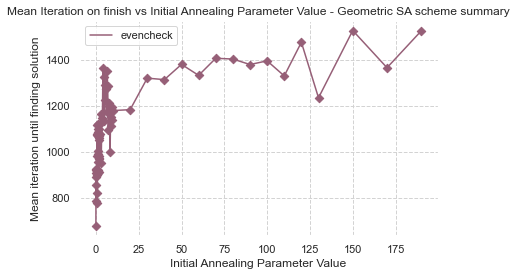

In [79]:
plot_scatter([summary_geom_temp[summary_geom_temp.potential==0.].groupby('annealing_param').mean()], 
             legend=['evencheck'], 
             save_path=CHARTS_MAIN_PATH, 
             column='iteration',
             title='Mean Iteration on finish vs Initial Annealing Parameter Value - Geometric SA scheme summary',
             xlabel='Initial Annealing Parameter Value',
             ylabel='Mean iteration until finding solution',
            )

In [80]:
summary_linear_temp = concat_data([even_gate_linear_0005_2,
                                   even_gate_linear_1_35,
                                   even_gate_linear_10_200_20
                                  ],
                                  flags=['0005_2', '1_35', '10_200'],
                                  columns={'iteration', 'annealing_param', 'potential'}
                                 )

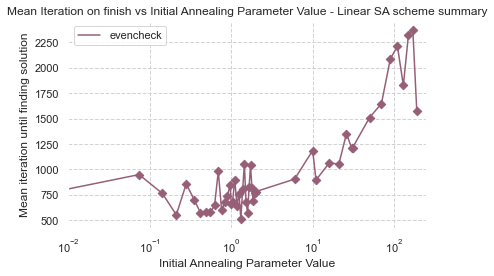

In [81]:
plot_scatter([summary_linear_temp[summary_linear_temp.potential==0.].groupby(['annealing_param']).mean()],
             legend=['evencheck'], 
             save_path=CHARTS_MAIN_PATH, 
             column='iteration',
             title='Mean Iteration on finish vs Initial Annealing Parameter Value - Linear SA scheme summary',
             xlabel='Initial Annealing Parameter Value',
             ylabel='Mean iteration until finding solution',
             xscale='log',
             xlim=(0.01,250)
            )

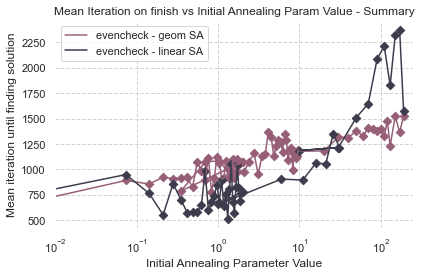

In [82]:
plot_scatter([calc_mns_series(summary_geom_temp, groupby='annealing_param'), 
             calc_mns_series(summary_linear_temp, groupby='annealing_param')], 
             legend=['evencheck - geom SA', 'evencheck - linear SA'], 
             save_path=CHARTS_MAIN_PATH, 
             column='mns',
             title='Mean Iteration on finish vs Initial Annealing Param Value - Summary',
             xlabel='Initial Annealing Parameter Value',
             ylabel='Mean iteration until finding solution',
             xscale='log',
             xlim=(0.01,250)
            )

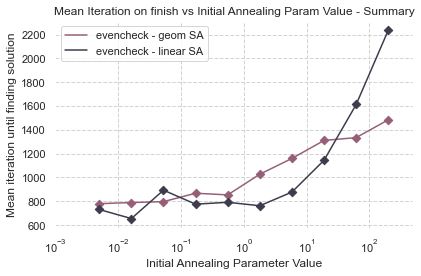

In [83]:
plot_scatter([calc_mns_series(even_gate_geom_log_summary, groupby='annealing_param'), 
             calc_mns_series(even_gate_linear_log_summary, groupby='annealing_param')], 
             legend=['evencheck - geom SA', 'evencheck - linear SA'], 
             save_path=CHARTS_MAIN_PATH, 
             column='mns',
             title='Mean Iteration on finish vs Initial Annealing Param Value - Summary',
             xlabel='Initial Annealing Parameter Value',
             ylabel='Mean iteration until finding solution',
             xscale='log',
             xlim=(0.001, 500)
            )

### Calculate CR for summary of optimal temperatures

#### geom SA

In [84]:
geom_cr_diff_annealing_param = calc_cr_series(even_gate_geom_log_summary, groupby='annealing_param')

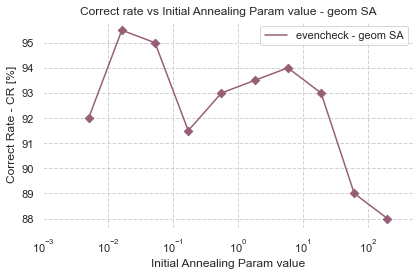

In [85]:
plot_scatter([geom_cr_diff_annealing_param],
             legend=['evencheck - geom SA'],
             save_path=CHARTS_MAIN_PATH,
             column='cr',
             title='Correct rate vs Initial Annealing Param value - geom SA',
             ylabel='Correct Rate - CR [%]',
             xlabel='Initial Annealing Param value',
             xscale='log',
             xlim=(0.001, 500)
            )

#### linear SA

In [86]:
linear_cr_diff_annealing_param = calc_cr_series(even_gate_linear_log_summary, groupby='annealing_param')

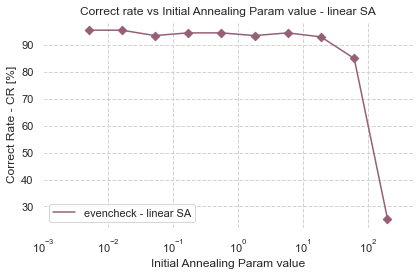

In [87]:
plot_scatter([linear_cr_diff_annealing_param],
             legend=['evencheck - linear SA'],
             save_path=CHARTS_MAIN_PATH,
             column='cr',
             title='Correct rate vs Initial Annealing Param value - linear SA',
             ylabel='Correct Rate - CR [%]',
             xlabel='Initial Annealing Param value',
             xscale='log',
             xlim=(0.001, 500)
            )

### CR and MNS on one chart - EVENCHECK

#### ANNEALING PARAM

In [88]:
def double_axis_plot(dataset_1: pd.DataFrame, 
                     dataset_2: pd.DataFrame,  
                     save_path: pathlib.Path,
                     legend: List[str],
                     plot_type: str,
                     title: str,
                     xlabel: str,
                     y_1_label: str,
                     y_2_label: str,
                     x: str,
                     y_1: str = 'mns',
                     y_2: str = 'cr',
                     xscale: str = None,
                     xlim = None,
                     yscale = None,
                     marker: str = 'D',
                     colors: List[str] = colors,
                    ) -> None:

    fig, ax1 = plt.subplots()
    
    if plot_type == 'plot':
        
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y_1_label, color=colors[0])
        ax1.set_title(title)
        ax1.tick_params(axis='y', labelcolor=colors[0])
        
        ax1.scatter(dataset_1[x], dataset_1[y_1], color=colors[0], marker=marker)
        ax1.plot(dataset_1[x], dataset_1[y_1], color=colors[0])

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel(y_2_label, color=colors[1])  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelcolor=colors[1])
        
        ax2.scatter(dataset_1[x], dataset_2[y_2], color=colors[1], marker=marker)
        ax2.plot(dataset_1[x], dataset_2[y_2], color=colors[1])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.grid(color='lightgray', linestyle='--', linewidth=1)
        plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')
        
    if plot_type == 'scatter':
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y_1_label, color=colors[0])
        ax1.set_title(title)
        ax1.tick_params(axis='y', labelcolor=colors[0])
        
        ax1.scatter(dataset_1[x], dataset_1[y_1], color=colors[0], marker=marker)
        ax1.plot(dataset_1[x], dataset_1[y_1], color=colors[0])

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel(y_2_label, color=colors[1])  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelcolor=colors[1])
        ax2.scatter(dataset_1[x], dataset_2[y_2], color=colors[1], marker=marker)
        ax2.plot(dataset_1[x], dataset_2[y_2], color=colors[1])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.grid(color='lightgray', linestyle='--', linewidth=1)
        if xscale:
            plt.xscale(xscale)
        if yscale:
            plt.yscale(yscale)
        if xlim:
            plt.xlim(xlim)
        plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')
        
    if plot_type == 'bar':
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y_1_label, color=colors[0])
        ax1.set_title(title)
        ax1.tick_params(axis='y', labelcolor=colors[0])
        
        ax1.bar(dataset_1[x], dataset_1[y_1], color=colors[0])

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel(y_2_label, color=colors[1])  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelcolor=colors[1])
        ax2.bar(dataset_1[x], dataset_2[y_2], color=colors[1])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.grid(color='lightgray', linestyle='--', linewidth=1)
        plt.savefig(save_path / f'{title}.pdf', dpi=300, format='pdf')

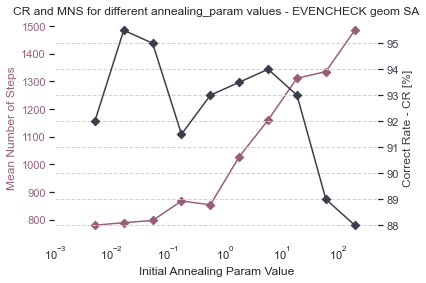

In [89]:
double_axis_plot(calc_mns_series(even_gate_geom_log_summary, groupby='annealing_param'),
                 calc_cr_series(even_gate_geom_log_summary, groupby='annealing_param'),
                 colors=colors,
                 save_path=CHARTS_MAIN_PATH,
                 legend=['mns', 'cr'],
                 plot_type='scatter',
                 title='CR and MNS for different annealing_param values - EVENCHECK geom SA',
                 xlabel='Initial Annealing Param Value',
                 y_1_label='Mean Number of Steps',
                 y_2_label='Correct Rate - CR [%]',
                 x='annealing_param',
                 y_1='mns',
                 y_2='cr',
                 xscale='log',
                 xlim=(0.001, 500)
                )

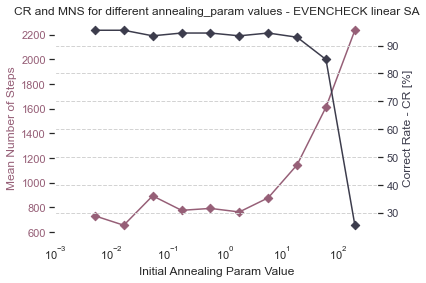

In [90]:
double_axis_plot(calc_mns_series(even_gate_linear_log_summary, groupby='annealing_param'),
                 calc_cr_series(even_gate_linear_log_summary, groupby='annealing_param'),
                 colors=colors,
                 save_path=CHARTS_MAIN_PATH,
                 legend=['mns', 'cr'],
                 plot_type='scatter',
                 title='CR and MNS for different annealing_param values - EVENCHECK linear SA',
                 xlabel='Initial Annealing Param Value',
                 y_1_label='Mean Number of Steps',
                 y_2_label='Correct Rate - CR [%]',
                 x='annealing_param',
                 y_1='mns',
                 y_2='cr',
                 xscale='log',
                 xlim=(0.001, 500)
                )

#### MAX_STEPS

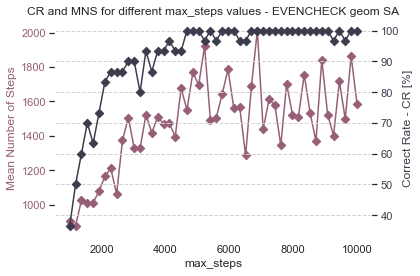

In [91]:
double_axis_plot(calc_mns_series(df_max_step_detailed_geom_evencheck, groupby='max_steps'),
                 calc_cr_series(df_max_step_detailed_geom_evencheck, groupby='max_steps'),
                 colors=colors,
                 save_path=CHARTS_MAIN_PATH,
                 legend=['mns', 'cr'],
                 plot_type='plot',
                 title='CR and MNS for different max_steps values - EVENCHECK geom SA',
                 xlabel='max_steps',
                 y_1_label='Mean Number of Steps',
                 y_2_label='Correct Rate - CR [%]',
                 x='max_steps',
                 y_1='mns',
                 y_2='cr'
                )

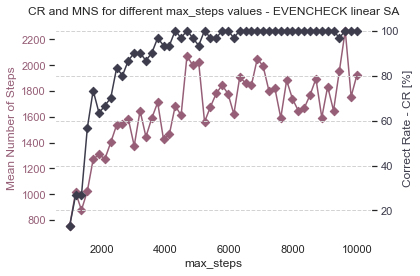

In [92]:
double_axis_plot(calc_mns_series(df_max_step_detailed_linear_evencheck, groupby='max_steps'),
                 calc_cr_series(df_max_step_detailed_linear_evencheck, groupby='max_steps'),
                 colors=colors,
                 save_path=CHARTS_MAIN_PATH,
                 legend=['mns', 'cr'],
                 plot_type='plot',
                 title='CR and MNS for different max_steps values - EVENCHECK linear SA',
                 xlabel='max_steps',
                 y_1_label='Mean Number of Steps',
                 y_2_label='Correct Rate - CR [%]',
                 x='max_steps',
                 y_1='mns',
                 y_2='cr'
                )

#### best params SA

EVENCHECK GEOM

max_step = 4000
annealing_param = 25

EVENCHECK LINEAR

max_step = 4000
annealing_param = 15


## best params plot - EVENCHECK

In [93]:
df_evencheck_cgp_geom_best_params_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "evencheck_gate_best_params_geom.csv")
df_evencheck_cgp_lin_best_params_raw = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / "evencheck_gate_best_params_linear.csv")

df_cgp_evencheck_best_params = concat_data([df_evencheck_cgp_geom_best_params_raw, 
                                     df_evencheck_cgp_lin_best_params_raw, 
                                     df_evencheck_cgp_alone_raw], 
                                    flags=['geom', 'lin', 'cgp_alone'])

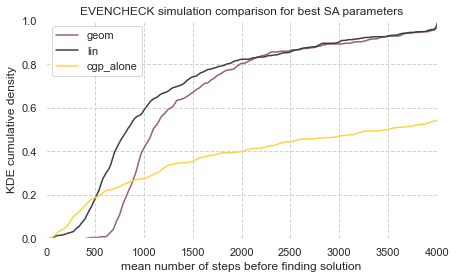

In [94]:
plot_hist_line(data=df_cgp_evencheck_best_params,
               title='EVENCHECK simulation comparison for best SA parameters',
               ylabel='KDE cumulative density',
               xlabel='mean number of steps before finding solution',
               column='iteration',
               schemes=['geom', 'lin', 'cgp_alone'],
               save_path=CHARTS_MAIN_PATH,
               xlim=(0, 4000)
              )

In [95]:
calc_cr_series(df_cgp_evencheck_best_params, groupby='sa_type')

,sa_type,cr
geom,geom,96.00
lin,lin,96.33
cgp_alone,cgp_alone,56.33


In [96]:
calc_mns_series(df_cgp_evencheck_best_params, groupby='sa_type')

,sa_type,mns
geom,geom,1378.67
lin,lin,1137.61
cgp_alone,cgp_alone,1427.35


## plot CR and MNS

### EVENCHECK

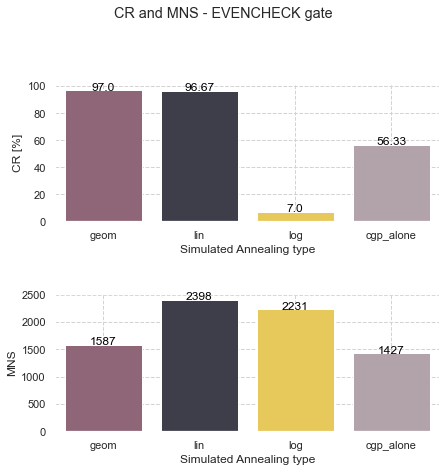

In [97]:
plot_bar(df_cgp_evencheck_data,
         save_path = CHARTS_MAIN_PATH,
         title='CR and MNS - EVENCHECK gate',
        )

#### Best params

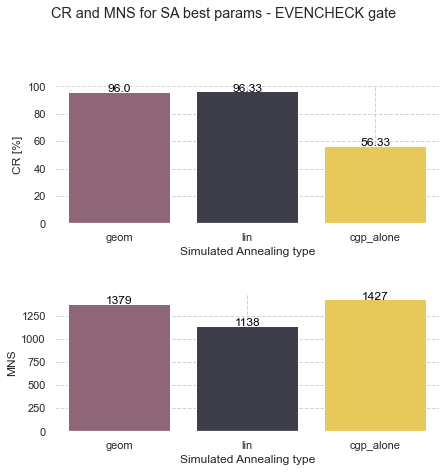

In [98]:
plot_bar(df_cgp_evencheck_best_params,
         save_path = CHARTS_MAIN_PATH,
         title='CR and MNS for SA best params - EVENCHECK gate',
        )

### RANDOM_2

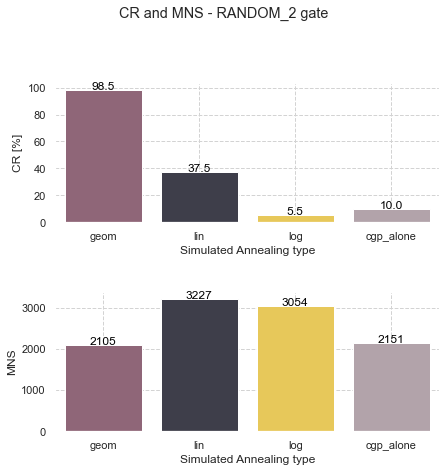

In [99]:
plot_bar(df_cgp_random2_data,
         save_path = CHARTS_MAIN_PATH,
         title='CR and MNS - RANDOM_2 gate'
        )

### AND

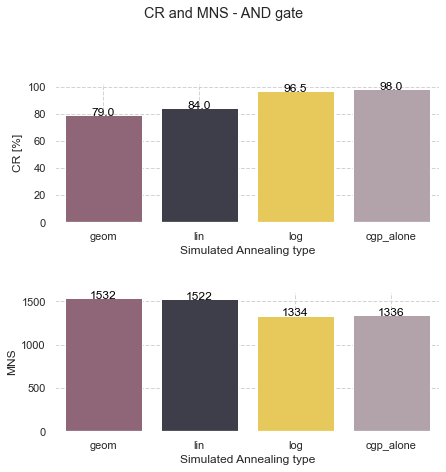

In [100]:
plot_bar(df_cgp_and_data,
         save_path = CHARTS_MAIN_PATH,
         title='CR and MNS - AND gate',
        )

## Objective function vs time

### evencheck

In [101]:
df_obj_func_geom_sa = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'every_step_momentum_data_evencheck_gate_geom_sa.txt')
df_obj_func_none_sa = pd.read_csv(EVENCHECK_GATE_CGP_PATH / 'every_step_momentum_data_evencheck_gate_cgp_alone_sa.txt')
df_obj_func_linear_sa = pd.read_csv(EVENCHECK_GATE_CGPSA_PATH / 'every_step_momentum_data_evencheck_gate_linear_sa.txt')

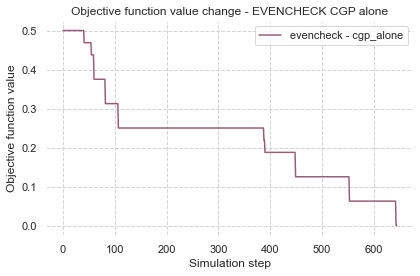

In [102]:
plot_line([df_obj_func_none_sa],
          legend=['evencheck - cgp_alone'],
          title='Objective function value change - EVENCHECK CGP alone',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )

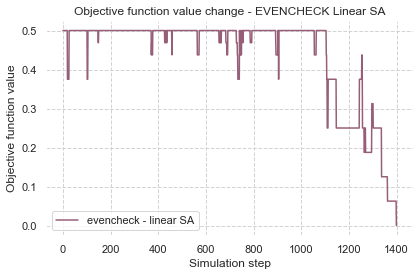

In [103]:
plot_line([df_obj_func_linear_sa],
          legend=['evencheck - linear SA'],
          title='Objective function value change - EVENCHECK Linear SA',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )

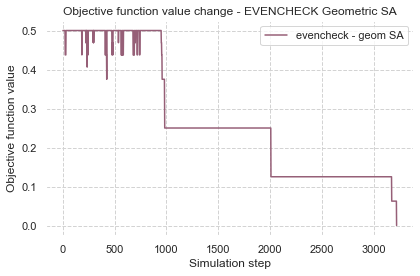

In [104]:
plot_line([df_obj_func_geom_sa],
          legend=['evencheck - geom SA'],
          title='Objective function value change - EVENCHECK Geometric SA',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )

### random_2

In [105]:
df_obj_func_random_geom_sa = pd.read_csv(RANDOM_GATE_CGPSA_PATH / 'every_step_momentum_data_random_gate_geom_sa.txt')
df_obj_func_random_linear_sa = pd.read_csv(RANDOM_GATE_CGPSA_PATH / 'every_step_momentum_data_random_gate_linear_sa.txt')
df_obj_func_random_cgp_alone = pd.read_csv(RANDOM_GATE_CGP_PATH / 'every_step_momentum_data_random_gate_cgp_alone_sa.txt')

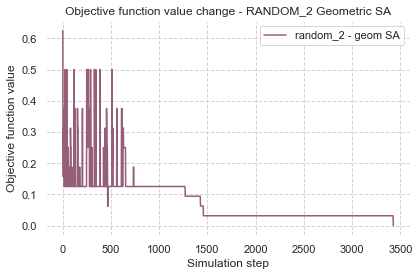

In [106]:
plot_line([df_obj_func_random_geom_sa],
          legend=['random_2 - geom SA'],
          title='Objective function value change - RANDOM_2 Geometric SA',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )

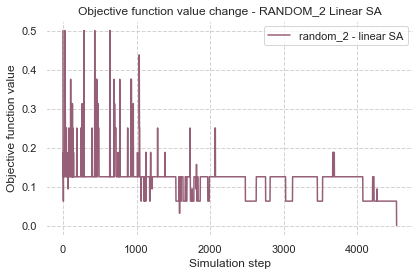

In [107]:
plot_line([df_obj_func_random_linear_sa],
          legend=['random_2 - linear SA'],
          title='Objective function value change - RANDOM_2 Linear SA',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )

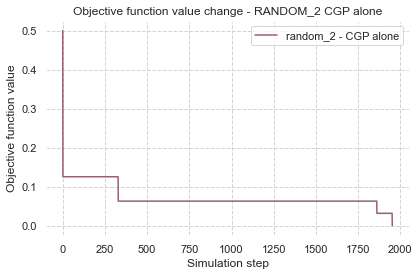

In [108]:
plot_line([df_obj_func_random_cgp_alone],
          legend=['random_2 - CGP alone'],
          title='Objective function value change - RANDOM_2 CGP alone',
          ylabel='Objective function value',
          xlabel='Simulation step',
          column='potential',
          save_path=CHARTS_MAIN_PATH,
         )